In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

In [5]:
df_train = pd.read_excel('./data/train_clientes.xlsx', index_col='ID_CORRELATIVO')
df_test = pd.read_excel('./data/test_clientes.xlsx', index_col='ID_CORRELATIVO')
df_train_req = pd.read_excel('./data/train_requerimientos.xlsx', index_col='ID_CORRELATIVO')
df_test_req = pd.read_excel('./data/test_requerimientos.xlsx', index_col='ID_CORRELATIVO')

## Data Clientes

In [36]:
x_train = df_train.drop(['ATTRITION'], axis=1)
y_train = df_train['ATTRITION']
x_test = df_test

In [37]:
# Join train and test df to aplly feature engineering
df = pd.concat([x_train, x_test])
print df.shape

(100000, 51)


In [38]:
# Split columns by type
num_cols = df.select_dtypes(exclude=['datetime', 'object']).columns.tolist()
cat_cols = [col for col in df.columns if col not in num_cols]

In [39]:
df[cat_cols].describe(include=['object'])

,RANG_INGRESO,FLAG_LIMA_PROVINCIA,RANG_SDO_PASIVO_MENOS0,RANG_NRO_PRODUCTOS_MENOS0
count,86445,95101,100000,100000
unique,9,2,15,6
top,Rang_ingreso_01,Lima,Rango_SDO_01,Rango_02
freq,22019,59549,39013,53222


In [41]:
dm1 = pd.get_dummies(df[cat_cols[0]], prefix='FLAG')
dm2 = pd.get_dummies(df[cat_cols[1]], prefix='FLAG')
dm3 = pd.get_dummies(df[cat_cols[2]], prefix='FLAG')
dm4 = pd.get_dummies(df[cat_cols[3]], prefix='FLAG')

df_ = pd.concat([df, dm1, dm2, dm3, dm4], axis=1)
df_.drop(cat_cols, inplace=True, axis=1)

In [44]:
# Drop CODMES
df_.drop('CODMES', inplace=True, axis=1)
num_cols.remove('CODMES')

## Modelado clientes

In [106]:
from sklearn.model_selection import KFold
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

In [144]:
x_train_ = df.iloc[0:70000]
x_test_ = df.iloc[70000:]

class SklearnHelper(object):
    def __init__(self, clf, seed=1234, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        
kf = KFold(n_splits=5, random_state=1234)  
SEED = 1234
        
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((x_train_.shape[0],))
    oof_test = np.zeros((x_test_.shape[0],))
    oof_test_skf = np.empty((SEED, x_test_.shape[0]))

    for i, (train_index, test_index) in enumerate(kf.split(x_train_)):
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train.iloc[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [145]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [109]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [ ]:
rf_oof_train, rf_oof_test = get_oof(rf, x_train_, y_train, x_test_)
et_oof_train, et_oof_test = get_oof(et, x_train_, y_train, x_test_)
ada_oof_train, ada_oof_test = get_oof(ada, x_train_, y_train, x_test_)
gb_oof_train, gb_oof_test = get_oof(gb, x_train_, y_train, x_test_)
svc_oof_train, svc_oof_test = get_oof(svc, x_train_, y_train, x_test_)

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [50]:
x_train_ = df_.iloc[0:70000]
x_test_ = df_.iloc[70000:]

xtrain, xtest, ytrain, ytest = train_test_split(x_train_, y_train, test_size=.10, random_state=1234)

### XGBoost

In [51]:
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dtest = xgb.DMatrix(xtest, label=ytest)

params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta':.1,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'binary:logistic',
    'eval_metric':'logloss'
}

xgb_model = xgb.train(params, 
                      dtrain,
                      num_boost_round=999, 
                      early_stopping_rounds=10,
                      evals=[(dtest, "Test")])

[0]	Test-logloss:0.635735
Will train until Test-logloss hasn't improved in 10 rounds.
[1]	Test-logloss:0.588944
[2]	Test-logloss:0.550046
[3]	Test-logloss:0.517694
[4]	Test-logloss:0.490148
[5]	Test-logloss:0.466872
[6]	Test-logloss:0.446736
[7]	Test-logloss:0.429389
[8]	Test-logloss:0.4142
[9]	Test-logloss:0.401065
[10]	Test-logloss:0.38962
[11]	Test-logloss:0.379838
[12]	Test-logloss:0.370969
[13]	Test-logloss:0.363243
[14]	Test-logloss:0.356188
[15]	Test-logloss:0.349831
[16]	Test-logloss:0.344631
[17]	Test-logloss:0.340236
[18]	Test-logloss:0.336214
[19]	Test-logloss:0.332781
[20]	Test-logloss:0.329503
[21]	Test-logloss:0.326578
[22]	Test-logloss:0.32431
[23]	Test-logloss:0.32217
[24]	Test-logloss:0.319906
[25]	Test-logloss:0.318416
[26]	Test-logloss:0.316852
[27]	Test-logloss:0.315557
[28]	Test-logloss:0.314393
[29]	Test-logloss:0.313427
[30]	Test-logloss:0.312669
[31]	Test-logloss:0.311397
[32]	Test-logloss:0.310451
[33]	Test-logloss:0.309845
[34]	Test-logloss:0.309354
[35]	Test-

In [52]:
xgb.cv(
    params, 
    xgb.DMatrix(x_train_, label=y_train), 
    num_boost_round=999,
    early_stopping_rounds=10, 
    nfold=5, 
    seed=1234,
    metrics='logloss'
)

,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std
0,0.636049,0.000160,0.635839,0.000108
1,0.589436,0.000336,0.588957,0.000183
2,0.550851,0.000437,0.550131,0.000304
3,0.518459,0.000521,0.517522,0.000397
4,0.491284,0.000739,0.490012,0.000368
5,0.467901,0.000886,0.466488,0.000430
6,0.447924,0.000969,0.446317,0.000479
7,0.430846,0.001054,0.429002,0.000435
8,0.415846,0.001158,0.413712,0.000439
9,0.402931,0.001159,0.400502,0.000477


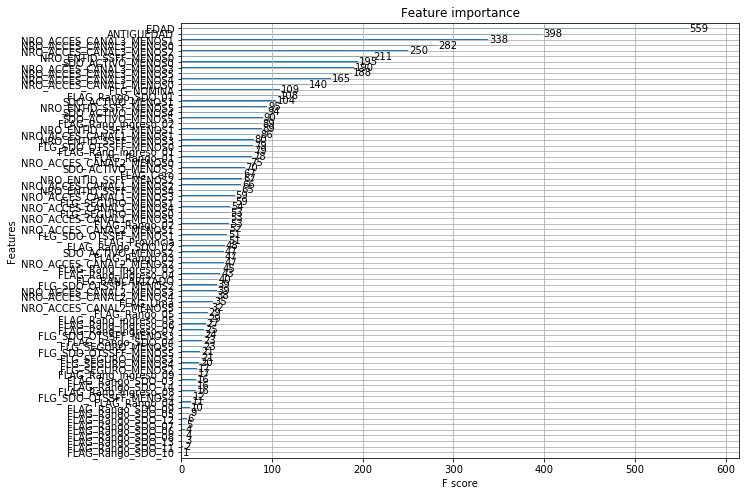

In [53]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, height=0.2, ax=ax)

In [54]:
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV 

def modelfit(alg, xtrain, ytrain, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xtrain, label=ytrain)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xtrain, ytrain, eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(xtrain)
    dtrain_predprob = alg.predict_proba(xtrain)[:,1]
    
    mean_logloss = cvresult['test-logloss-mean'].min()
    boost_rounds = cvresult.shape[0]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(ytrain, dtrain_predictions)
    print "Logloss (Train): %f" % metrics.log_loss(ytrain, dtrain_predprob)
    print "Logloss (CV): %f" % mean_logloss
    print "Rounds (CV): {}".format(boost_rounds) 
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8846
Logloss (Train): 0.276349
Logloss (CV): 0.303707
Rounds (CV): 210


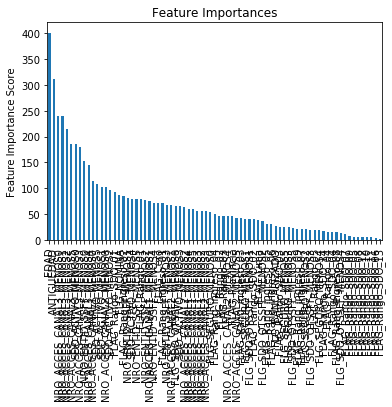

In [55]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=1234
)

modelfit(xgb1, x_train_, y_train)

In [56]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(
    estimator=XGBClassifier(learning_rate=0.1, 
                            n_estimators=210, 
                            max_depth=5,
                            min_child_weight=1, 
                            gamma=0, 
                            subsample=0.8, 
                            colsample_bytree=0.8,
                            objective='binary:logistic', 
                            nthread=-1, 
                            scale_pos_weight=1, 
                            seed=1234), 
    param_grid=param_test1, 
    scoring='neg_log_loss',
    n_jobs=-1,
    iid=False, 
    cv=5
)

gsearch1.fit(x_train_, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=210, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='neg_log_loss',
       verbose=0)

([mean: -0.31122, std: 0.00182, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.31116, std: 0.00209, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.31132, std: 0.00193, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.30301, std: 0.00183, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.30325, std: 0.00203, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.30325, std: 0.00212, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.30239, std: 0.00166, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.30169, std: 0.00209, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.30118, std: 0.00235, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.30605, std: 0.00208, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.30300, std: 0.00268, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.30195, std: 0.00268, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_chil

In [ ]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(
    estimator=XGBClassifier(learning_rate=0.1, 
                            n_estimators=210, 
                            max_depth=7,
                            min_child_weight=5, 
                            gamma=0, 
                            subsample=0.8, 
                            colsample_bytree=0.8,
                            objective='binary:logistic', 
                            nthread=-1, 
                            scale_pos_weight=1, 
                            seed=1234), 
    param_grid = param_test3, 
    scoring='neg_log_loss',
    n_jobs=-1,
    iid=False, 
    cv=5
)

gsearch3.fit(x_train_, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_


Model Report
Accuracy : 0.8883
Logloss (Train): 0.270288
Logloss (CV): 0.300635
Rounds (CV): 104


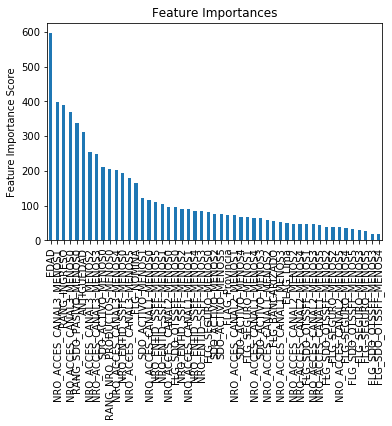

In [31]:
xgb2 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=7,
    min_child_weight=5,
    gamma=0.4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=1234
)

modelfit(xgb2, x_train_, y_train)

In [32]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)]
}

gsearch4 = GridSearchCV(
    estimator=XGBClassifier(learning_rate=0.1, 
                            n_estimators=104, 
                            max_depth=7,
                            min_child_weight=5, 
                            gamma=0.4, 
                            subsample=0.8, 
                            colsample_bytree=0.8,
                            objective='binary:logistic', 
                            nthread=-1, 
                            scale_pos_weight=1, 
                            seed=1234), 
    param_grid = param_test4, 
    scoring='neg_log_loss',
    n_jobs=-1,
    iid=False, 
    cv=5
)

gsearch4.fit(x_train_, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=104, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='neg_log_loss',
       verbose=0)

([mean: -0.30031, std: 0.00212, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -0.29999, std: 0.00196, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -0.29974, std: 0.00196, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -0.29963, std: 0.00207, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: -0.29972, std: 0.00181, params: {'subsample': 1.0, 'colsample_bytree': 0.6},
  mean: -0.30048, std: 0.00167, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -0.29969, std: 0.00252, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -0.29989, std: 0.00234, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -0.29990, std: 0.00192, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -0.30017, std: 0.00246, params: {'subsample': 1.0, 'colsample_bytree': 0.7},
  mean: -0.30083, std: 0.00192, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: -0.29996, std: 0.00224, params: {'subsample': 0.7, 'colsa

In [33]:
param_test5 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch5 = GridSearchCV(
    estimator=XGBClassifier(learning_rate=0.1, 
                            n_estimators=104, 
                            max_depth=7,
                            min_child_weight=5, 
                            gamma=0.4, 
                            subsample=0.7, 
                            colsample_bytree=1.0,
                            objective='binary:logistic', 
                            nthread=-1, 
                            scale_pos_weight=1, 
                            seed=1234), 
    param_grid = param_test5, 
    scoring='neg_log_loss',
    n_jobs=-1,
    iid=False, 
    cv=5
)

gsearch5.fit(x_train_, y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1.0,
       gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=104, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.7),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='neg_log_loss',
       verbose=0)

([mean: -0.29941, std: 0.00238, params: {'reg_alpha': 1e-05},
  mean: -0.29977, std: 0.00229, params: {'reg_alpha': 0.01},
  mean: -0.29988, std: 0.00227, params: {'reg_alpha': 0.1},
  mean: -0.29940, std: 0.00269, params: {'reg_alpha': 1},
  mean: -0.31459, std: 0.00095, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 -0.2994022444018273)


Model Report
Accuracy : 0.8879
Logloss (Train): 0.271470
Logloss (CV): 0.300614
Rounds (CV): 96


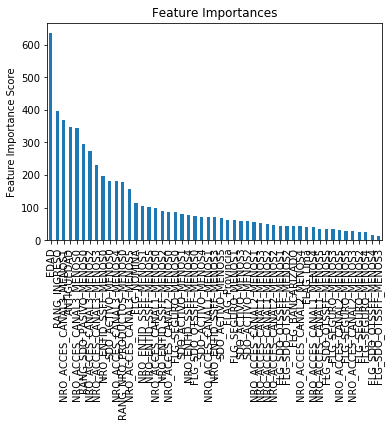

In [34]:
xgb3 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=7,
    min_child_weight=5,
    gamma=0.4,
    subsample=0.7,
    colsample_bytree=1.0,
    reg_alpha=1,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=1234
)
modelfit(xgb3, x_train_, y_train)


Model Report
Accuracy : 0.8898
Logloss (Train): 0.264732
Logloss (CV): 0.298676
Rounds (CV): 1225


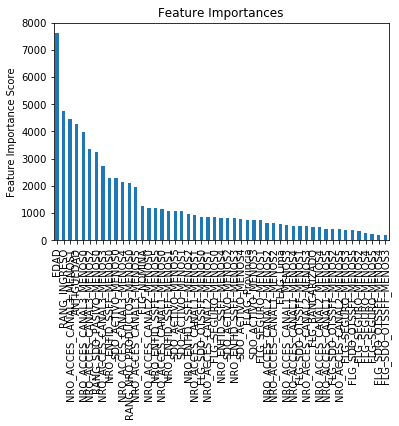

In [35]:
xgb4 = XGBClassifier(
    learning_rate=0.01,
    n_estimators=5000,
    max_depth=7,
    min_child_weight=5,
    gamma=0.4,
    subsample=0.7,
    colsample_bytree=1.0,
    reg_alpha=1,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=1234)
modelfit(xgb4, x_train_, y_train)

In [52]:
best_xgb = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1290,
    max_depth=7,
    min_child_weight=5,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.6,
    reg_alpha=1,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=1234)

best_xgb.fit(xtrain, ytrain, eval_metric='logloss')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=7,
       min_child_weight=5, missing=None, n_estimators=1290, nthread=-1,
       objective='binary:logistic', reg_alpha=1, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.9)

In [57]:
y_pred = best_xgb.predict_proba(x_test_)[:,1]
submission = pd.DataFrame()
submission['ID_CORRELATIVO'] = x_test.index
submission['ATTRITION'] = y_pred
submission.head()

submission.to_csv('./data/submission11.csv', index=False)

,ID_CORRELATIVO,ATTRITION
0,47411,0.319422
1,39861,0.331425
2,38898,0.023454
3,50927,0.017122
4,32969,0.341649


### LightGBM

In [54]:
# Lightgbm

dtrain =lgb.Dataset(xtrain,label=ytrain)
dtest = lgb.Dataset(xtest,label=ytest)

params = {'objective': 'binary',
          'max_depth': 7,
          'learning_rate': .01,
          'colsample_bytree': 0.6, 
          'max_bin': 200,
          'metric': 'binary_logloss',
          'reg_alpha': 1,
          'reg_lambda': 1,
          'is_unbalanced': True}


lgb_model = lgb.train(params,
                      dtrain,
                      num_boost_round=5000,
                      early_stopping_rounds=10,
                      valid_sets=[dtest, dtrain],
                      valid_names=["Test", "Train"]
                      )

[1]	Train's binary_logloss: 0.687571	Test's binary_logloss: 0.687553
Training until validation scores don't improve for 10 rounds.
[2]	Train's binary_logloss: 0.681821	Test's binary_logloss: 0.681785
[3]	Train's binary_logloss: 0.676374	Test's binary_logloss: 0.676353
[4]	Train's binary_logloss: 0.671057	Test's binary_logloss: 0.671037
[5]	Train's binary_logloss: 0.666191	Test's binary_logloss: 0.666197
[6]	Train's binary_logloss: 0.660993	Test's binary_logloss: 0.661013
[7]	Train's binary_logloss: 0.656298	Test's binary_logloss: 0.656332
[8]	Train's binary_logloss: 0.65098	Test's binary_logloss: 0.650979
[9]	Train's binary_logloss: 0.646036	Test's binary_logloss: 0.646046
[10]	Train's binary_logloss: 0.641301	Test's binary_logloss: 0.641281
[11]	Train's binary_logloss: 0.636313	Test's binary_logloss: 0.636262
[12]	Train's binary_logloss: 0.631511	Test's binary_logloss: 0.631437
[13]	Train's binary_logloss: 0.627127	Test's binary_logloss: 0.627055
[14]	Train's binary_logloss: 0.623109	

[125]	Train's binary_logloss: 0.384212	Test's binary_logloss: 0.383772
[126]	Train's binary_logloss: 0.383223	Test's binary_logloss: 0.38277
[127]	Train's binary_logloss: 0.382251	Test's binary_logloss: 0.3818
[128]	Train's binary_logloss: 0.381243	Test's binary_logloss: 0.380775
[129]	Train's binary_logloss: 0.380449	Test's binary_logloss: 0.379978
[130]	Train's binary_logloss: 0.379538	Test's binary_logloss: 0.379081
[131]	Train's binary_logloss: 0.378659	Test's binary_logloss: 0.378204
[132]	Train's binary_logloss: 0.377695	Test's binary_logloss: 0.377231
[133]	Train's binary_logloss: 0.376874	Test's binary_logloss: 0.376424
[134]	Train's binary_logloss: 0.376022	Test's binary_logloss: 0.375588
[135]	Train's binary_logloss: 0.375265	Test's binary_logloss: 0.374836
[136]	Train's binary_logloss: 0.37435	Test's binary_logloss: 0.373908
[137]	Train's binary_logloss: 0.37373	Test's binary_logloss: 0.3733
[138]	Train's binary_logloss: 0.372865	Test's binary_logloss: 0.372424
[139]	Train's

[249]	Train's binary_logloss: 0.324017	Test's binary_logloss: 0.324079
[250]	Train's binary_logloss: 0.32378	Test's binary_logloss: 0.323854
[251]	Train's binary_logloss: 0.323508	Test's binary_logloss: 0.32357
[252]	Train's binary_logloss: 0.323272	Test's binary_logloss: 0.323342
[253]	Train's binary_logloss: 0.323091	Test's binary_logloss: 0.323153
[254]	Train's binary_logloss: 0.322859	Test's binary_logloss: 0.32293
[255]	Train's binary_logloss: 0.322599	Test's binary_logloss: 0.322673
[256]	Train's binary_logloss: 0.32245	Test's binary_logloss: 0.32254
[257]	Train's binary_logloss: 0.322214	Test's binary_logloss: 0.32232
[258]	Train's binary_logloss: 0.321957	Test's binary_logloss: 0.322066
[259]	Train's binary_logloss: 0.321707	Test's binary_logloss: 0.321813
[260]	Train's binary_logloss: 0.321561	Test's binary_logloss: 0.321677
[261]	Train's binary_logloss: 0.321361	Test's binary_logloss: 0.32149
[262]	Train's binary_logloss: 0.321182	Test's binary_logloss: 0.321313
[263]	Train's

[365]	Train's binary_logloss: 0.306863	Test's binary_logloss: 0.307836
[366]	Train's binary_logloss: 0.306795	Test's binary_logloss: 0.30779
[367]	Train's binary_logloss: 0.306684	Test's binary_logloss: 0.30769
[368]	Train's binary_logloss: 0.306579	Test's binary_logloss: 0.307591
[369]	Train's binary_logloss: 0.306485	Test's binary_logloss: 0.307506
[370]	Train's binary_logloss: 0.306421	Test's binary_logloss: 0.307464
[371]	Train's binary_logloss: 0.306327	Test's binary_logloss: 0.307395
[372]	Train's binary_logloss: 0.306273	Test's binary_logloss: 0.307359
[373]	Train's binary_logloss: 0.306212	Test's binary_logloss: 0.307331
[374]	Train's binary_logloss: 0.306112	Test's binary_logloss: 0.307248
[375]	Train's binary_logloss: 0.306058	Test's binary_logloss: 0.307203
[376]	Train's binary_logloss: 0.305989	Test's binary_logloss: 0.307144
[377]	Train's binary_logloss: 0.305932	Test's binary_logloss: 0.307096
[378]	Train's binary_logloss: 0.305861	Test's binary_logloss: 0.307049
[379]	Tr

[486]	Train's binary_logloss: 0.298988	Test's binary_logloss: 0.301809
[487]	Train's binary_logloss: 0.298944	Test's binary_logloss: 0.301792
[488]	Train's binary_logloss: 0.298898	Test's binary_logloss: 0.301765
[489]	Train's binary_logloss: 0.298837	Test's binary_logloss: 0.30171
[490]	Train's binary_logloss: 0.298789	Test's binary_logloss: 0.301677
[491]	Train's binary_logloss: 0.29875	Test's binary_logloss: 0.301648
[492]	Train's binary_logloss: 0.298676	Test's binary_logloss: 0.301587
[493]	Train's binary_logloss: 0.298624	Test's binary_logloss: 0.301558
[494]	Train's binary_logloss: 0.298571	Test's binary_logloss: 0.301527
[495]	Train's binary_logloss: 0.298528	Test's binary_logloss: 0.301498
[496]	Train's binary_logloss: 0.298474	Test's binary_logloss: 0.301469
[497]	Train's binary_logloss: 0.298431	Test's binary_logloss: 0.301448
[498]	Train's binary_logloss: 0.298385	Test's binary_logloss: 0.301426
[499]	Train's binary_logloss: 0.298333	Test's binary_logloss: 0.301383
[500]	Tr

[607]	Train's binary_logloss: 0.293953	Test's binary_logloss: 0.29902
[608]	Train's binary_logloss: 0.293904	Test's binary_logloss: 0.298992
[609]	Train's binary_logloss: 0.293871	Test's binary_logloss: 0.298988
[610]	Train's binary_logloss: 0.29384	Test's binary_logloss: 0.298971
[611]	Train's binary_logloss: 0.293807	Test's binary_logloss: 0.298956
[612]	Train's binary_logloss: 0.29377	Test's binary_logloss: 0.298948
[613]	Train's binary_logloss: 0.293743	Test's binary_logloss: 0.298933
[614]	Train's binary_logloss: 0.293705	Test's binary_logloss: 0.298918
[615]	Train's binary_logloss: 0.293675	Test's binary_logloss: 0.298906
[616]	Train's binary_logloss: 0.293635	Test's binary_logloss: 0.298894
[617]	Train's binary_logloss: 0.293605	Test's binary_logloss: 0.29888
[618]	Train's binary_logloss: 0.293559	Test's binary_logloss: 0.298845
[619]	Train's binary_logloss: 0.293528	Test's binary_logloss: 0.298831
[620]	Train's binary_logloss: 0.293493	Test's binary_logloss: 0.298813
[621]	Trai

[728]	Train's binary_logloss: 0.290225	Test's binary_logloss: 0.297743
[729]	Train's binary_logloss: 0.290202	Test's binary_logloss: 0.29774
[730]	Train's binary_logloss: 0.290176	Test's binary_logloss: 0.297742
[731]	Train's binary_logloss: 0.290148	Test's binary_logloss: 0.29774
[732]	Train's binary_logloss: 0.290116	Test's binary_logloss: 0.297734
[733]	Train's binary_logloss: 0.290081	Test's binary_logloss: 0.297718
[734]	Train's binary_logloss: 0.290052	Test's binary_logloss: 0.297705
[735]	Train's binary_logloss: 0.290028	Test's binary_logloss: 0.297703
[736]	Train's binary_logloss: 0.290001	Test's binary_logloss: 0.297705
[737]	Train's binary_logloss: 0.289981	Test's binary_logloss: 0.297699
[738]	Train's binary_logloss: 0.289956	Test's binary_logloss: 0.29769
[739]	Train's binary_logloss: 0.289932	Test's binary_logloss: 0.29768
[740]	Train's binary_logloss: 0.289908	Test's binary_logloss: 0.297675
[741]	Train's binary_logloss: 0.289878	Test's binary_logloss: 0.297675
[742]	Trai

[847]	Train's binary_logloss: 0.287084	Test's binary_logloss: 0.297012
[848]	Train's binary_logloss: 0.287065	Test's binary_logloss: 0.297016
[849]	Train's binary_logloss: 0.287031	Test's binary_logloss: 0.297006
[850]	Train's binary_logloss: 0.287015	Test's binary_logloss: 0.297013
[851]	Train's binary_logloss: 0.286988	Test's binary_logloss: 0.297006
[852]	Train's binary_logloss: 0.286965	Test's binary_logloss: 0.297006
[853]	Train's binary_logloss: 0.28694	Test's binary_logloss: 0.297001
[854]	Train's binary_logloss: 0.286923	Test's binary_logloss: 0.296993
[855]	Train's binary_logloss: 0.286901	Test's binary_logloss: 0.296994
[856]	Train's binary_logloss: 0.28688	Test's binary_logloss: 0.297001
[857]	Train's binary_logloss: 0.286858	Test's binary_logloss: 0.297
[858]	Train's binary_logloss: 0.286828	Test's binary_logloss: 0.296991
[859]	Train's binary_logloss: 0.286799	Test's binary_logloss: 0.296987
[860]	Train's binary_logloss: 0.286771	Test's binary_logloss: 0.296975
[861]	Train

[965]	Train's binary_logloss: 0.284294	Test's binary_logloss: 0.296459
[966]	Train's binary_logloss: 0.284272	Test's binary_logloss: 0.296458
[967]	Train's binary_logloss: 0.28425	Test's binary_logloss: 0.296453
[968]	Train's binary_logloss: 0.284227	Test's binary_logloss: 0.296457
[969]	Train's binary_logloss: 0.284201	Test's binary_logloss: 0.29645
[970]	Train's binary_logloss: 0.28418	Test's binary_logloss: 0.296449
[971]	Train's binary_logloss: 0.284157	Test's binary_logloss: 0.296448
[972]	Train's binary_logloss: 0.284125	Test's binary_logloss: 0.29645
[973]	Train's binary_logloss: 0.284098	Test's binary_logloss: 0.296448
[974]	Train's binary_logloss: 0.284078	Test's binary_logloss: 0.296445
[975]	Train's binary_logloss: 0.284039	Test's binary_logloss: 0.296424
[976]	Train's binary_logloss: 0.284015	Test's binary_logloss: 0.296422
[977]	Train's binary_logloss: 0.283994	Test's binary_logloss: 0.296431
[978]	Train's binary_logloss: 0.283973	Test's binary_logloss: 0.296423
[979]	Trai

[1082]	Train's binary_logloss: 0.281798	Test's binary_logloss: 0.296052
[1083]	Train's binary_logloss: 0.281777	Test's binary_logloss: 0.296047
[1084]	Train's binary_logloss: 0.281766	Test's binary_logloss: 0.296044
[1085]	Train's binary_logloss: 0.281745	Test's binary_logloss: 0.296048
[1086]	Train's binary_logloss: 0.281733	Test's binary_logloss: 0.296047
[1087]	Train's binary_logloss: 0.281707	Test's binary_logloss: 0.29604
[1088]	Train's binary_logloss: 0.281686	Test's binary_logloss: 0.296052
[1089]	Train's binary_logloss: 0.281663	Test's binary_logloss: 0.296054
[1090]	Train's binary_logloss: 0.281637	Test's binary_logloss: 0.296047
[1091]	Train's binary_logloss: 0.281611	Test's binary_logloss: 0.296051
[1092]	Train's binary_logloss: 0.281593	Test's binary_logloss: 0.296052
[1093]	Train's binary_logloss: 0.281576	Test's binary_logloss: 0.296054
[1094]	Train's binary_logloss: 0.281559	Test's binary_logloss: 0.296051
[1095]	Train's binary_logloss: 0.281539	Test's binary_logloss: 0.

In [55]:
lgb.cv(params,
       dtrain,
       nfold=5,
       num_boost_round=5000,
       early_stopping_rounds=10,
       seed=1234)

{u'binary_logloss-mean': [0.68758818779006314,
  0.68184530791242903,
  0.67643258323239097,
  0.67113891148061344,
  0.66628083643420188,
  0.66110283782584944,
  0.65641669408961001,
  0.65111624228632969,
  0.64619843051025605,
  0.64146233044476453,
  0.63650593532187405,
  0.63172640874809505,
  0.62735963238131287,
  0.62336215248481541,
  0.61874192381973947,
  0.61424278957343625,
  0.61003856998751194,
  0.6056848590736289,
  0.60138189329485392,
  0.59749164480159878,
  0.59331702161694666,
  0.5891870159627397,
  0.58543856240005643,
  0.58164331899596167,
  0.57797114367651292,
  0.57437139338416843,
  0.57086474530150366,
  0.56767525762304716,
  0.56426777174885134,
  0.56058019300850237,
  0.55730775399585419,
  0.55372089334336305,
  0.55031287781049365,
  0.5469101313277227,
  0.54380846139644634,
  0.54083243627057109,
  0.53803564941561055,
  0.53488057638262343,
  0.53173564670758255,
  0.52908646951691751,
  0.52629572814738224,
  0.52353818842351241,
  0.520802639

In [96]:
# Catboost

cat_index = np.where(xtrain.dtypes != np.int64)[0]
xtrain_ = xtrain.fillna(-999)
xtest_ = xtest.fillna(-999)

cat = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='Logloss')
cat.fit(xtrain_, ytrain, cat_features=cat_index, eval_set=(xtest_, ytest))

0:	learn: 0.6098000	test: 0.6087800	best: 0.6087800 (0)	total: 435ms	remaining: 43s
1:	learn: 0.5467892	test: 0.5441933	best: 0.5441933 (1)	total: 800ms	remaining: 39.2s
2:	learn: 0.5015840	test: 0.4982920	best: 0.4982920 (2)	total: 1.14s	remaining: 36.9s
3:	learn: 0.4691119	test: 0.4654975	best: 0.4654975 (3)	total: 1.49s	remaining: 35.7s
4:	learn: 0.4389794	test: 0.4348695	best: 0.4348695 (4)	total: 1.79s	remaining: 34.1s
5:	learn: 0.4171453	test: 0.4125541	best: 0.4125541 (5)	total: 2.11s	remaining: 33s
6:	learn: 0.3982106	test: 0.3934618	best: 0.3934618 (6)	total: 2.43s	remaining: 32.3s
7:	learn: 0.3841852	test: 0.3793456	best: 0.3793456 (7)	total: 2.79s	remaining: 32.1s
8:	learn: 0.3757456	test: 0.3713988	best: 0.3713988 (8)	total: 3.15s	remaining: 31.9s
9:	learn: 0.3685541	test: 0.3641463	best: 0.3641463 (9)	total: 3.51s	remaining: 31.6s
10:	learn: 0.3619128	test: 0.3573016	best: 0.3573016 (10)	total: 3.88s	remaining: 31.4s
11:	learn: 0.3558871	test: 0.3513764	best: 0.3513764 (11

94:	learn: 0.3057021	test: 0.3074299	best: 0.3074299 (94)	total: 31.5s	remaining: 1.66s
95:	learn: 0.3056104	test: 0.3073789	best: 0.3073789 (95)	total: 31.9s	remaining: 1.33s
96:	learn: 0.3055520	test: 0.3074203	best: 0.3073789 (95)	total: 32.3s	remaining: 998ms
97:	learn: 0.3055381	test: 0.3073959	best: 0.3073789 (95)	total: 32.5s	remaining: 664ms
98:	learn: 0.3053205	test: 0.3072782	best: 0.3072782 (98)	total: 33s	remaining: 333ms
99:	learn: 0.3051673	test: 0.3072003	best: 0.3072003 (99)	total: 33.4s	remaining: 0us

bestTest = 0.3072002593
bestIteration = 99



In [155]:
from catboost import cv, Pool

params ={
    'depth': 6,
    'learning_rate': .3,
    'iterations': 100,
    'loss_function': 'Logloss'
}

cv(params, Pool(xtrain_, ytrain),  partition_random_seed=1234, fold_count=5)

defaultdict(list,
            {'Logloss_test_avg': [0.4992888798495029,
              0.4189291033306059,
              0.3782191481513616,
              0.3572729975492328,
              0.34632590722627965,
              0.33932788336109293,
              0.33473707224145544,
              0.3317226791487664,
              0.3290086879876494,
              0.32687337374238623,
              0.3247977269548841,
              0.323433527133473,
              0.32175615140042846,
              0.3205685524203222,
              0.3195858745058834,
              0.31899249059056184,
              0.31815216013750286,
              0.3175485817610718,
              0.31666524716132416,
              0.3162278075960517,
              0.31556478096128543,
              0.3149183770647865,
              0.3143178069018428,
              0.3138846461676707,
              0.3133332220388815,
              0.3129980126591327,
              0.3126408143544389,
              0.3123464560290848,
  

In [161]:
x_test__ = x_test_.fillna(-999)

submission = pd.DataFrame()
submission['ID_CORRELATIVO'] = x_test__.index
submission['ATTRITION'] = np.transpose(cat.predict_proba(x_test__))[1]
submission.head()
submission.to_csv('./data/submission9.csv', index=False)

,ID_CORRELATIVO,ATTRITION
0,47411,0.218305
1,39861,0.246614
2,38898,0.020136
3,50927,0.051046
4,32969,0.255357


## Modelado requerimientos

In [217]:
x_req = df_train_req.join(y_train).drop('ATTRITION', axis=1)
y_req = df_train_req.join(y_train)['ATTRITION']
x_req.fillna(-999, inplace=True)

In [218]:
x_train_req, x_test_req, y_train_req, y_test_req = train_test_split(x_req, y_req, test_size=.10, random_state=1234)

In [219]:
cat_feat_index = np.where(x_req.dtypes != np.int64)[0]

cat = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6)
cat.fit(x_train_req, y_train_req, cat_features=cat_feat_index, eval_set=(x_test_req, y_test_req))

0:	learn: 0.6044600	test: 0.6031466	best: 0.6031466 (0)	total: 113ms	remaining: 11.2s
1:	learn: 0.5360142	test: 0.5335257	best: 0.5335257 (1)	total: 154ms	remaining: 7.53s
2:	learn: 0.4833144	test: 0.4797636	best: 0.4797636 (2)	total: 211ms	remaining: 6.82s
3:	learn: 0.4425946	test: 0.4381694	best: 0.4381694 (3)	total: 287ms	remaining: 6.89s
4:	learn: 0.4113655	test: 0.4060800	best: 0.4060800 (4)	total: 328ms	remaining: 6.22s
5:	learn: 0.3870200	test: 0.3810510	best: 0.3810510 (5)	total: 455ms	remaining: 7.12s
6:	learn: 0.3683349	test: 0.3616980	best: 0.3616980 (6)	total: 545ms	remaining: 7.24s
7:	learn: 0.3538443	test: 0.3465183	best: 0.3465183 (7)	total: 621ms	remaining: 7.14s
8:	learn: 0.3425319	test: 0.3346711	best: 0.3346711 (8)	total: 746ms	remaining: 7.54s
9:	learn: 0.3337013	test: 0.3253680	best: 0.3253680 (9)	total: 811ms	remaining: 7.3s
10:	learn: 0.3265408	test: 0.3178328	best: 0.3178328 (10)	total: 898ms	remaining: 7.26s
11:	learn: 0.3211377	test: 0.3120240	best: 0.3120240 

95:	learn: 0.2972434	test: 0.2859774	best: 0.2859765 (94)	total: 8.42s	remaining: 351ms
96:	learn: 0.2971881	test: 0.2859623	best: 0.2859623 (96)	total: 8.54s	remaining: 264ms
97:	learn: 0.2971674	test: 0.2859644	best: 0.2859623 (96)	total: 8.66s	remaining: 177ms
98:	learn: 0.2971250	test: 0.2859578	best: 0.2859578 (98)	total: 8.8s	remaining: 88.8ms
99:	learn: 0.2970371	test: 0.2859411	best: 0.2859411 (99)	total: 8.99s	remaining: 0us

bestTest = 0.2859410566
bestIteration = 99



In [57]:
from catboost import cv, Pool

params ={
    'depth': 6,
    'learning_rate': .1,
    'iterations': 100,
    'loss_function': 'Logloss'
}

cv(params, Pool(x_train_req, y_train_req, cat_features=cat_feat_index),  partition_random_seed=1234, fold_count=5)

defaultdict(list,
            {'Logloss_test_avg': [0.6044590655482499,
              0.5358769341370746,
              0.4831631361206874,
              0.44266836665059667,
              0.41130337126945904,
              0.387199392487251,
              0.36854173334588264,
              0.35395704295215674,
              0.34267024847766736,
              0.33383455044077237,
              0.3268189790347938,
              0.32134512608824817,
              0.3170148265141174,
              0.31358654291561605,
              0.3108858404954843,
              0.3087493540895614,
              0.30703190890868537,
              0.3056071108638281,
              0.3044784752974292,
              0.30361880765614996,
              0.30287648987621496,
              0.30227719167405254,
              0.30180587338820675,
              0.30143048209180734,
              0.3011080926921161,
              0.30076702870558575,
              0.30057768507970434,
              0.3003539898528

In [305]:
df_test_req['ATTRITION_REQ'] = cat.predict_proba(df_test_req)[:, 1]

df_test_req_ = df_test_req.groupby(by=df_test_req.index)['ATTRITION_REQ'].mean()

new_submission = pd.DataFrame(index=x_test_.index)
new_submission['ATT'] = y_pred
new_submission.head()

,ATT
ID_CORRELATIVO,
47411,0.291465
39861,0.269891
38898,0.028191
50927,0.019253
32969,0.470753


In [306]:
df_test_req_ = new_submission.join(df_test_req_)
df_test_req_['ATTRITION'] = df_test_req_.apply(lambda x: np.mean(x), axis=1)

In [307]:
df_test_req_.reset_index(inplace=True)
df_test_req_[['ID_CORRELATIVO', 'ATTRITION']].to_csv('./data/submission11.csv', index=False)